## Sentiment Analysis on US Airline Reviews

‚Ä¢	Overview of Sentiment Analysis: Sentiment analysis is the process of interpreting text data's emotional tone automatically. It seeks to ascertain if a text conveys a positive, negative emotion. 

‚Ä¢	Using of sentiment Analysis: we use it for monitoring and identifying the comments that the user writes in the store Section in our App.

‚Ä¢	Importance of NLP and LSTM in Sentiment Analysis: Sentiment analysis relies heavily on two critical tools: Natural Language Processing (NLP) and Long Short-Term Memory (LSTM) networks. These tools work together to provide accurate results.

Natural Language Processing (NLP): NLP forms the basis for understanding the text data   used in sentiment analysis. It provides techniques for several tasks including:
Text Preprocessing: Breaking down text into smaller units, such as words, and cleaning them by removing punctuation and stop words.

Tokenization: Convert the text into a sequence of tokens, which are individual words.

Feature Engineering: Extracting relevant features from text that can be used by a sentiment analysis model. This involves converting words into numerical representations identifying parts of speech.

Long Short-Term Memory (LSTM) networks: LSTM networks are a specific type of recurrent neural network (RNN) that are well suited for processing sequential data, such as text, which can have a variable length and may contain ambiguous or multiple meanings. In sentiment analysis, understanding the order and relationship between words is crucial for accurate sentiment detection.
 LSTM networks have a special architecture that allows them to learn long-term dependencies in data. This is important because the sentiment of a sentence can be influenced by words that appear earlier. For instance, the sentence "The movie was awful, but the acting was great" expresses a mixed sentiment, and LSTM networks can capture this nuance by considering the relationship between "awful" and the overall sentiment.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding

df = pd.read_csv(r"/content/drive/MyDrive/nlp_grad_proj/Tweets.csv")

### Dataset 

To train our sentiment analysis model, we utilized a comprehensive dataset that specifically focused on airline customer experience. This dataset, consisting of 14,640 tweets, was gathered in February 2015 through the process of scraping Twitter conversations.

‚Ä¢	Targeted Tweets for Focused Analysis: Unlike some sentiment analysis datasets that encompass a wide range of topics, this study concentrated on customer tweets. This targeted approach enables us to train the model on text specifically related to the aviation industry, ensuring that it understands the nuances of customer sentiments.
‚Ä¢	Class Distribution and Imbalance Considerations: The dataset exhibited a class imbalance, with a significant skew towards negative sentiment. There were 9,178 negative tweets compared to 2,363 positive tweets. This imbalance can pose challenges for the model as it may be more likely to learn patterns associated with negativity.


In [3]:
df.head()

tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1                    NaN    jnardino                 NaN              0   
2                    NaN  yvonnalynn                 NaN              0   
3                    NaN    jnardino                 NaN              0   
4                    NaN    jnardino                 NaN              0   

                                                text tweet_coord  \
0                @VirginAmerica What @dhepburn said.         NaN   
1  @VirginAmerica plus you've added commercials t...         NaN   
2  @VirginAmerica I didn't today... Must mean I n...         NaN   
3  @VirginAmerica it's really aggressive to blast...         NaN   
4  @VirginAmerica and it's a really big bad thing...         NaN   

               tweet_created tweet_location               user_timezone  
0  2015-02-24 11:35:52 -0800            NaN  Eastern Time (US & Canada)  
1  2015-02-24 11:15:59 -0800            NaN  Pacific Time (US & Canada)  
2  2015-02-24 11:15:48 -0800      Lets Play  Central Time (US & Canada)  
3  2015-02-24 11:15:36 -0800            NaN  Pacific Time (US & Canada)  
4  2015-02-24 11:14:45 -0800            NaN  Pacific Time (US & Canada)

In [4]:
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [5]:
tweet_df = df[['text','airline_sentiment']]
print(tweet_df.shape)
tweet_df.head(5)

(14640, 2)


text airline_sentiment
0                @VirginAmerica What @dhepburn said.           neutral
1  @VirginAmerica plus you've added commercials t...          positive
2  @VirginAmerica I didn't today... Must mean I n...           neutral
3  @VirginAmerica it's really aggressive to blast...          negative
4  @VirginAmerica and it's a really big bad thing...          negative

In [6]:
tweet_df = tweet_df[tweet_df['airline_sentiment'] != 'neutral']
print(tweet_df.shape)
tweet_df.head(5)

(11541, 2)


text airline_sentiment
1  @VirginAmerica plus you've added commercials t...          positive
3  @VirginAmerica it's really aggressive to blast...          negative
4  @VirginAmerica and it's a really big bad thing...          negative
5  @VirginAmerica seriously would pay $30 a fligh...          negative
6  @VirginAmerica yes, nearly every time I fly VX...          positive

In [7]:
tweet_df["airline_sentiment"].value_counts()

negative    9178
positive    2363
Name: airline_sentiment, dtype: int64

In [8]:
sentiment_label = tweet_df.airline_sentiment.factorize()
sentiment_label

(array([0, 1, 1, ..., 0, 1, 1]),
 Index(['positive', 'negative'], dtype='object'))

### Text Preprocessing

Preparing the Text for Analysis Before inputting our extensive collection of tweets into the LSTM model, it is essential to preprocess the text data. This critical step ensures that the model can effectively comprehend and analyze the sentiments expressed in each tweet. Text preprocessing involves a series of techniques that transform raw text into a format that the model can readily comprehend.

‚Ä¢	Tokenization: Breaking Down the Text into Meaningful Units The first step in preprocessing is tokenization. Here, we essentially disassemble each tweet into its individual building blocks, words. Tokenization functions similarly to breaking down the complex sentence structure of a tweet into individual words (tokens) that the model can recognize and process.

‚Ä¢	Tokenizer with 5,000 Words: Focusing on the Most Informative Vocabulary Although tweets can encompass a vast vocabulary, many words may not be particularly informative for sentiment analysis. Words such as "the," "a," or "an" are frequent but nonsentiment-bearing words that can clutter the data. To address this issue, we can employ a tokenizer trained on a large corpus of text data. This tokenizer identifies and retains the most frequent (5,000) words, effectively creating a vocabulary that is most relevant for understanding sentiment in airline tweets. This focused vocabulary reduces the complexity of the data for the model to handle, while preserving sentiment-rich words.

‚Ä¢	Maintaining Uniformity in Model Input: The Importance of Padding The length of tweets varied, with some being short like "Flight delayed again!" and the others are lengthy, with multiple sentences. This inconsistency in tweet length poses challenges for the LSTM model, which expects sequences of a uniform size. To address this, we employed a padding technique. Padding involves adding unique tokens (zero) at the beginning of each tweet to ensure that all sequences have the same length (200 tokens). This enables LSTM to effectively process each tweet within its internal architecture


In [9]:
tweet = tweet_df.text.values
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(tweet)
vocab_size = len(tokenizer.word_index) + 1
encoded_docs = tokenizer.texts_to_sequences(tweet)
padded_sequence = pad_sequences(encoded_docs, maxlen=200)

In [10]:
print(tokenizer.word_index)

{'to': 1, 'the': 2, 'i': 3, 'a': 4, 'united': 5, 'you': 6, 'for': 7, 'flight': 8, 'and': 9, 'on': 10, 'my': 11, 'usairways': 12, 'americanair': 13, 'is': 14, 'in': 15, 'southwestair': 16, 'of': 17, 'jetblue': 18, 'me': 19, 'your': 20, 'it': 21, 'was': 22, 'not': 23, 'no': 24, 'have': 25, 'at': 26, 'with': 27, 'that': 28, 'this': 29, 'get': 30, 'but': 31, 'be': 32, 'cancelled': 33, 'thanks': 34, 'now': 35, 'service': 36, 'are': 37, 'we': 38, 'from': 39, 'an': 40, 'been': 41, 'just': 42, '2': 43, 'so': 44, 'customer': 45, 'help': 46, 't': 47, 'can': 48, 'time': 49, 'co': 50, 'up': 51, 'hours': 52, 'http': 53, 'do': 54, 'hold': 55, 'they': 56, 'out': 57, 'amp': 58, 'plane': 59, "i'm": 60, 'us': 61, 'all': 62, 'will': 63, 'why': 64, 'thank': 65, 'still': 66, 'our': 67, 'delayed': 68, 'what': 69, 'when': 70, 'how': 71, 'one': 72, "can't": 73, 'flights': 74, 'call': 75, 'gate': 76, 'hour': 77, 'had': 78, 'flightled': 79, 'back': 80, 'bag': 81, 'if': 82, 'would': 83, 'after': 84, 'has': 85, '

In [18]:
print(tweet[0])
print(encoded_docs[0])

@VirginAmerica plus you've added commercials to the experience... tacky.
[103, 575, 530, 1287, 2416, 1, 2, 177]


In [19]:
print(padded_sequence[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0  103  575  530 1287
 2416 

### Model Training

Model Architecture: We defines a sequential model with layers specifically designed for text analysis tasks. Here's a breakdown of the visible layers:

o	Embedding Layer: This layer converts words into numerical representations.

o	LSTM Layer: This layer is a type of recurrent neural network (RNN) that can handle sequential data like text, and it captures long-term dependencies in the sequences.

o	Dropout Layer: This layer helps prevent the model from overfitting by randomly dropping out neurons during training.

o	Dense Layer: This layer is used to map the output of the LSTM layer to a single unit with a sigmoid activation function, likely for generating a binary output (positive or negative sentiment).

‚Ä¢	Loss Function and Optimizer: We use "binary_crossentropy" loss function, which is commonly used for binary classification tasks, and "adam" optimizer, which is an algorithm used to adjust the weights of the model during training to minimize the loss.

‚Ä¢	Training: The model is trained on the preprocessed data. This involves feeding the text data and corresponding sentiment labels into the model, and the optimizer adjusts the weights of the model to improve its accuracy in predicting sentiment on unseen data.


In [21]:
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200) )
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 200, 32)           423488    
                                                                 
 spatial_dropout1d_3 (Spati  (None, 200, 32)           0         
 alDropout1D)                                                    
                                                                 
 lstm_3 (LSTM)               (None, 50)                16600     
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 440139 (1.68 MB)
Trainable params: 440139 (1.68 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [22]:
history = model.fit(padded_sequence,sentiment_label[0],validation_split=0.2, epochs=5, batch_size=32)

Epoch 1/5
289/289 [==============================] - 89s 291ms/step - loss: 0.3964 - accuracy: 0.8356 - val_loss: 0.2070 - val_accuracy: 0.9225
Epoch 2/5
289/289 [==============================] - 83s 285ms/step - loss: 0.2177 - accuracy: 0.9162 - val_loss: 0.1652 - val_accuracy: 0.9363
Epoch 3/5
289/289 [==============================] - 81s 282ms/step - loss: 0.1729 - accuracy: 0.9366 - val_loss: 0.2249 - val_accuracy: 0.9277
Epoch 4/5
289/289 [==============================] - 80s 278ms/step - loss: 0.1511 - accuracy: 0.9448 - val_loss: 0.1810 - val_accuracy: 0.9428
Epoch 5/5
289/289 [==============================] - 83s 288ms/step - loss: 0.1181 - accuracy: 0.9549 - val_loss: 0.1809 - val_accuracy: 0.9454


### Model Performance

The training loss, measured using the binary cross-entropy function, indicates how well the model fits the training data. Lower loss signifies better model performance at predicting positive or negative sentiment labels for the training examples.

Evaluation on Test Data: The performance of the LSTM model on the unseen test dataset was assessed using several key metrics, including accuracy, precision, recall, and F1-score. The results are as follows:
‚Ä¢	Accuracy: 0.965. This indicates that the model correctly classified 96.5% of the tweets in the test set as either positive or negative sentiment. 
 
where TP = True positive; FP = False positive; TN = True negative; FN = False negative

‚Ä¢	Recall: The model achieved a high recall value of 0.990, indicating successful identification of a large proportion of actual positive tweets with a low rate of False Negatives.

‚Ä¢	The precision value of 0.967 indicates that 96.7% of the tweets predicted as positive by the model were actually positive, resulting in a low rate of False Positives

‚Ä¢	The F1-score of 0.978, which combines precision and recall, suggests good overall performance of the model. 


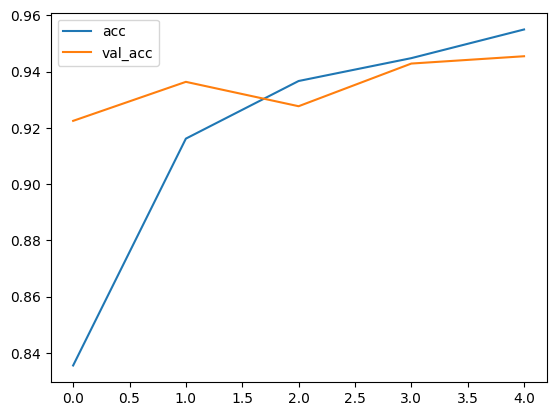

<Figure size 640x480 with 0 Axes>

In [25]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
plt.savefig("Accuracy plot.jpg")

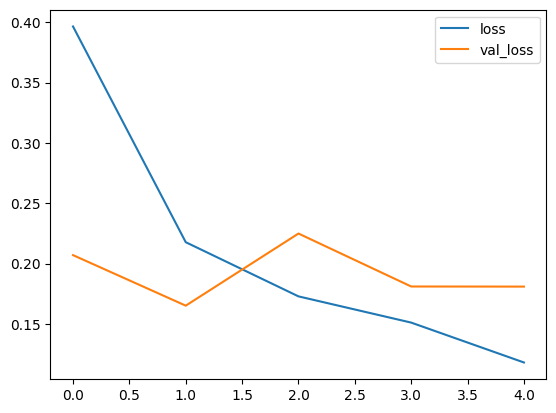

<Figure size 640x480 with 0 Axes>

In [26]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig("Loss plot.jpg")

In [27]:
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw,maxlen=200)
    prediction = int(model.predict(tw).round().item())
    print("Predicted label: ", sentiment_label[1][prediction])

In [39]:
test_sentence1 = "the worst product u can get "
predict_sentiment(test_sentence1)



1/1 [==============================] - 0s 35ms/step
Predicted label:  negative


In [40]:
test_sentence2 = "the best product "
predict_sentiment(test_sentence2)

1/1 [==============================] - 0s 35ms/step
Predicted label:  positive


In [24]:
import tensorflow
model.save(r"/content/drive/MyDrive/nlp_grad_proj/sentiment.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Conclusion

Summary of Key Findings: This notebook presents the development and evaluation of a sentiment analysis model using Long Short-Term Memory (LSTM) networks. 
The LSTM model achieved good overall performance on the unseen test data, with an accuracy of 0.965, recall of 0.990, precision of 0.967, and F1-score of 0.978. The text indicates that the model accurately classified tweets as having either a positive or negative sentiment in the test set.
The high recall rate suggests that the model successfully identified most positive tweets with a low false negative rate. However, further analysis of errors, such as sarcasm detection and negation handling, is recommended to understand limitations and areas for improvement.
It is important to note the class imbalance.
Significance of LSTMs in Sentiment Analysis: Long Short-Term Memory (LSTM) networks have been found to be effective for sentiment analysis tasks due to their ability to handle sequential data like text. They can capture long-range dependencies within sentences, which is crucial for understanding sentiment expressed in tweets. However, LSTMs might struggle with sarcasm, negation, or complex sentence structures.
Future Directions for Model Improvement: Several potential improvements for future development of the model include data pre-processing. Examine methods for managing sarcasm, negation, and complex sentence structures during data pre-processing. This may include utilizing sentiment lexicons, part-of-speech tagging, or data augmentation techniques. Additionally, experiments with hyperparameter tuning, such as adjusting the learning rate or number of LSTM layers, to potentially enhance the model's performance and address any limitations identified during evaluation. Finally, consider implementing regularization techniques. To prevent overfitting and improve the model's generalization ability, regularization techniques such as dropout can be considered. Depending on the results and limitations identified, alternative model architectures like convolutional neural networks (CNNs) or transformer-based models can be explored. These architectures may offer advantages for specific types of sentiment analysis tasks. By addressing these areas for improvement, you can improve the effectiveness and robustness of the sentiment analysis model for future applications.
